In [1]:
import os
import math
import json
import datetime
import numpy as np
import pandas as pd

from tifffile import tifffile

from skimage import morphology, filters, transform, measure
from skimage.feature import peak_local_max

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib import cm

from scipy import stats, optimize
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.stats import levene
from scipy.ndimage import center_of_mass

def plane(X, a, b, c):
    '''equation for a plane for approximating background subtractions in cropped microscope images'''
    return(a*X[0] + b * X[1] + c)


class simpleStimData:
    '''
    class for interpreting data saved on the microscope during live-cell tracking and computer-
    generated opto experiments. Contains information about the state of the microscope, the images
    themselves, and has methods for background subtraction and some basic processing
    '''
    def __init__(self, folderpath):
        self.folderpath = folderpath
        self.xpath_rot = []
        self.ypath_rot = []
        self.assay_type = ''
        self.get_image_paths()
        self.get_stage_data()
        self.transform_mats = self.get_transformation_matrices()
        self.get_image_stacks()
        self.background_subtraction()
        
    def get_image_paths(self):
        
        # collect image paths within the folder
        try:
            im_path_list = np.sort([self.folderpath + '/' + i for i in np.sort(os.listdir(self.folderpath))])
        except:
            im_path_list = np.sort([self.folderpath + '/' + i.decode('ascii') for i in np.sort(os.listdir(self.folderpath))])

        self.ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])
        self.ch1_path_list = np.sort([i for i in im_path_list if 'channel001' in i])
        self.ch2_path_list = np.sort([i for i in im_path_list if 'channel002' in i])
        self.ch3_path_list = np.sort([i for i in im_path_list if 'channel003' in i])
        self.ch4_path_list = np.sort([i for i in im_path_list if 'channel004' in i])
        self.ch5_path_list = np.sort([i for i in im_path_list if 'channel005' in i])
        self.ch6_path_list = np.sort([i for i in im_path_list if 'channel006' in i])
        
    def get_stage_data(self):
        
        x_stage_sequence = []
        y_stage_sequence = []

        for i in range(len(self.ch0_path_list)):
            with tifffile.TiffFile(self.ch0_path_list[i]) as temptif:

                # collect stage coordinates from tiff metadata
                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])

                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)

        # convert to numpy arrays to make translation and rotation a little easier
        self.x_stage_sequence = np.array(x_stage_sequence)
        self.y_stage_sequence = np.array(y_stage_sequence)

        # center paths on the moment of stimulation
        x_translated = self.x_stage_sequence - self.x_stage_sequence[10] 
        y_translated = self.y_stage_sequence - self.y_stage_sequence[10]

        # calculate the initial direction of the cell in the first ten frames
        self.theta = np.arctan2(-np.average(np.diff(y_translated[:10])), np.average(np.diff(x_translated[:10])))

        # convert into 
        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - self.theta  + math.pi/2

        self.x_rotated = rho * np.cos(phi)
        self.y_rotated = rho * np.sin(phi)
        self.centering_x = self.x_stage_sequence[10]
        self.centering_y = self.y_stage_sequence[10]
        

    def get_transformation_matrices(self):
        # this lets us rotate and transform the microscopy data to standardize it based on cell movement
        
        temptif = tifffile.TiffFile(self.ch0_path_list[0])
        centering_matrix = np.array([[1, 0, -200],[0, 1, -200],[0, 0, 1]])
        affine_matrix = np.vstack([np.array([float(i) for i in temptif.shaped_metadata[0]['PixelSizeAffine'].split(';')]).reshape(2, 3), np.array([0, 0, 1])])
        rotation_matrix = np.array([[np.cos(self.theta), -np.sin(self.theta), 0], [np.sin(self.theta), np.cos(self.theta), 0], [0, 0, 1]])
        transformation_matrix = np.matmul(affine_matrix, centering_matrix)
        transformation_matrix = np.matmul(rotation_matrix, transformation_matrix)


        transformation_matrices = []
        for t in range(len(self.x_stage_sequence)):

            xt = (self.x_stage_sequence[t] - self.centering_x)
            yt = (self.y_stage_sequence[t] - self.centering_y)

            xr, yr, placeholder = np.matmul(rotation_matrix, np.array([xt, yt, 0]))
            translation_matrix = np.array([[1, 0, xr],[0, 1, yr],[0, 0, 1]])

            tm = np.matmul(translation_matrix, transformation_matrix)

            transformation_matrices.append(tm.copy())

        return(transformation_matrices)

        
    def get_image_stacks(self):
        
        # make some containers for the pixel intensity information
        self.ch0_stack = np.zeros((len(self.ch0_path_list), 400, 400))
        self.ch1_stack = np.zeros((len(self.ch1_path_list), 400, 400))
        self.ch2_stack = np.zeros((len(self.ch2_path_list), 400, 400))
        self.ch3_stack = np.zeros((len(self.ch3_path_list), 400, 400))
        self.ch4_stack = np.zeros((len(self.ch4_path_list), 400, 400))
        self.ch5_stack = np.zeros((len(self.ch5_path_list), 400, 400))
        self.ch6_stack = np.zeros((len(self.ch6_path_list), 400, 400))
        
        # and for elapsed time
        self.ch0_times = np.zeros(len(self.ch0_path_list))
        self.ch1_times = np.zeros(len(self.ch1_path_list))
        self.ch2_times = np.zeros(len(self.ch2_path_list))
        self.ch3_times = np.zeros(len(self.ch3_path_list))
        self.ch4_times = np.zeros(len(self.ch4_path_list))
        self.ch5_times = np.zeros(len(self.ch5_path_list))
        self.ch6_times = np.zeros(len(self.ch6_path_list))
        
        for i in range(len(self.ch0_path_list)):
            with tifffile.TiffFile(self.ch0_path_list[i]) as temptif:
                self.ch0_stack[i] = temptif.asarray()
                try:
                    self.ch0_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass

        for i in range(len(self.ch1_path_list)):
            with tifffile.TiffFile(self.ch1_path_list[i]) as temptif:
                self.ch1_stack[i] = temptif.asarray()
                try:
                    self.ch1_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch2_path_list)):
            with tifffile.TiffFile(self.ch2_path_list[i]) as temptif:
                self.ch2_stack[i] = temptif.asarray()
                try:
                    self.ch2_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch3_path_list)):
            with tifffile.TiffFile(self.ch3_path_list[i]) as temptif:
                self.ch3_stack[i] = temptif.asarray()
                try:
                    self.ch3_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch4_path_list)):
            with tifffile.TiffFile(self.ch4_path_list[i]) as temptif:
                self.ch4_stack[i] = temptif.asarray()
                try:
                    self.ch4_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch5_path_list)):
            with tifffile.TiffFile(self.ch5_path_list[i]) as temptif:
                self.ch5_stack[i] = temptif.asarray()
                try:
                    self.ch5_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch6_path_list)):
            with tifffile.TiffFile(self.ch6_path_list[i]) as temptif:
                self.ch6_stack[i] = temptif.asarray()
                try:
                    self.ch6_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
        
        
    def get_transformed_xy_coords(self, timepoint):
        xx, yy = np.meshgrid(np.arange(400), np.arange(400))
        zz = np.ones_like(xx)

        coords = np.array([xx.ravel(), yy.ravel(), zz.ravel()])
        y_um, x_um, placeholder = np.matmul(self.transform_mats[timepoint], coords)
        
        return(x_um.reshape(400,400), y_um.reshape(400,400))

    
    def background_subtraction(self):
        # fit a plane to the median of non-cell signal over the course of the experiment
        bgstack_ch0 = []
        bgstack_ch1 = []
        for T in range(len(self.ch0_stack)):
            bg_ch0 = self.ch0_stack[T].copy()
            bg_ch1 = self.ch1_stack[T].copy()
            cell = self.ch3_stack[T] == 1
            cell = morphology.binary_dilation(cell, selem = morphology.disk(10))
            bg_ch0[cell] = np.nan
            bg_ch1[cell] = np.nan
            bgstack_ch0.append(bg_ch0)
            bgstack_ch1.append(bg_ch1)

        measured_bg_ch0 = np.nanmedian(bgstack_ch0, axis = 0)
        measured_bg_ch1 = np.nanmedian(bgstack_ch1, axis = 0)
        xx, yy = np.meshgrid(np.arange(400), np.arange(400))
        zz_ch0 = measured_bg_ch0
        zz_ch1 = measured_bg_ch1

        xx = xx[np.isfinite(zz_ch0)]
        yy = yy[np.isfinite(zz_ch0)]
        zz_ch0 = zz_ch0[np.isfinite(zz_ch0)]
        zz_ch1 = zz_ch1[np.isfinite(zz_ch1)]

        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(plane, X, zz_ch0, p0 = [1, 1, 500])
        popt_ch1, pcov = optimize.curve_fit(plane, X, zz_ch1, p0 = [1, 1, 500])
        
        X = np.meshgrid(np.arange(400), np.arange(400))
        self.ch0_estimated_bg = plane(X, popt_ch0[0], popt_ch0[1], popt_ch0[2])
        self.ch1_estimated_bg = plane(X, popt_ch1[0], popt_ch1[1], popt_ch1[2])
    
    def calculate_global_dynamics(self):
        ch0_avg = []
        ch1_avg = []
        
        for T in range(len(self.ch0_stack)):
            try:
                ch0_F = np.average((self.ch0_stack[T] - self.ch0_estimated_bg)[self.ch3_stack[T] > 0])
                ch1_F = np.average((self.ch1_stack[T] - self.ch1_estimated_bg)[self.ch3_stack[T] > 0])
                
            except:
                ch0_F = np.nan
                ch1_F = np.nan
                
            ch0_avg.append(ch0_F)
            ch1_avg.append(ch1_F)
            
        self.ch0_dynamics = np.array(ch0_avg)
        self.ch1_dynamics = np.array(ch1_avg)
        
    def calculate_frontbackSignals(self):
        ch0_frontback = []
        ch1_frontback = []

        for T in range(len(self.ch0_stack)):

            try:
                xx, yy = np.meshgrid(np.arange(400), np.arange(400))
                xx -= 200
                yy -= 200

                regions = measure.regionprops((self.ch3_stack[T] > 0).astype(int), intensity_image = self.ch1_stack[T] - self.ch1_estimated_bg)
                yc, xc = regions[0].centroid
                yw, xw = regions[0].weighted_centroid
                direction = np.arctan2(yw - yc, xw - xc)

                dist = np.hypot(xx, yy)
                angle = np.arctan2(yy, xx)
                dmap = dist * np.cos(angle - direction)
                dmap[self.ch3_stack[T] == 0] = np.nan

                frontloc = np.unravel_index(np.nanargmax(dmap), dmap.shape)
                xx, yy = np.meshgrid(np.arange(400), np.arange(400))
                dmap2 = np.hypot(yy - frontloc[0], xx - frontloc[1])
                x, y = dmap2[self.ch3_stack[T] > 0], self.ch0_stack[T][self.ch3_stack[T] > 0] - self.ch0_estimated_bg[self.ch3_stack[T] > 0]
                bs, be, bn = stats.binned_statistic(x, y, statistic = 'mean', bins = np.arange(0, 101))

                y2 = self.ch1_stack[T][self.ch3_stack[T] > 0] - self.ch1_estimated_bg[self.ch3_stack[T] > 0]
                bs2, be, bn = stats.binned_statistic(x, y2, statistic = 'mean', bins = np.arange(0, 101))

            except:
                bs = np.zeros(100) + np.nan
                bs2 = np.zeros(100) + np.nan

            ch0_frontback.append(bs)
            ch1_frontback.append(bs2)
            
        self.ch0_frontback = ch0_frontback
        self.ch1_frontback = ch1_frontback
        
    def get_angular_representation(self):
        
        self.ch0_ring = []
        self.ch1_ring = []
        self.ch2_ring = []
        
        self.ringstack = []

        pixch0 = []
        pixch1 = []
        for T in range(10):
            if np.sum(self.ch3_stack[T]) > 0:
                vals = self.ch0_stack[T][self.ch3_stack[T] > 0] - self.ch0_estimated_bg[self.ch3_stack[T] > 0]
                pixch0 = np.hstack([pixch0, vals])
                vals = self.ch1_stack[T][self.ch3_stack[T] > 0] - self.ch1_estimated_bg[self.ch3_stack[T] > 0]
                pixch1 = np.hstack([pixch1, vals])
        ch0_basal = np.average(pixch0)
        ch1_basal = np.average(pixch1)


        for T in range(len(self.ch3_stack)):
            try:
                outer = self.ch3_stack[T] > 0

                inner = morphology.binary_erosion(outer, selem = morphology.disk(15))
                ring = morphology.binary_erosion(outer, selem = morphology.disk(1)) & ~inner

                self.ringstack.append(ring)

                yc, xc = center_of_mass(self.ch3_stack[T])

                yy, xx = np.where(ring)
                A = np.arctan2(-(yy - yc), (xx - xc)) + self.theta
                A = np.arctan2(-np.sin(A), np.cos(A))

                F = self.ch0_stack[T][ring] - self.ch0_estimated_bg[ring]
                F /= ch0_basal
                bs, be, bn = stats.binned_statistic(A, F, statistic = 'mean', bins = np.linspace(-math.pi, math.pi, 101))
                self.ch0_ring.append(bs)

                F = self.ch1_stack[T][ring] - self.ch1_estimated_bg[ring]
                F /= ch1_basal
                bs, be, bn = stats.binned_statistic(A, F, statistic = 'mean', bins = np.linspace(-math.pi, math.pi, 101))
                self.ch1_ring.append(bs)

                bs, be, bn = stats.binned_statistic(A, self.ch2_stack[T][ring], statistic = 'mean', bins = np.linspace(-math.pi, math.pi, 101))
                self.ch2_ring.append(bs)


            except:
                self.ch0_ring.append(np.zeros(100) + np.nan)
                self.ch1_ring.append(np.zeros(100) + np.nan)
                self.ch2_ring.append(np.zeros(100) + np.nan)
            
        self.ch0_ring = np.fliplr(self.ch0_ring)
        self.ch1_ring = np.fliplr(self.ch1_ring)
        self.ch2_ring = np.fliplr(self.ch2_ring)

    

def get_tform_mat(input_bin, theta):
    '''
    Given a binary image representing a single cell and an angle,
    generate the transformation matrix that allows for rotation about
    the center of mass of the binary input by theta
    '''

    input_lbl = measure.label(input_bin)
    region = measure.regionprops(input_lbl)[0]
    y_c, x_c = region.centroid

    c = np.cos(theta)
    s = np.sin(theta)
    t_y = -y_c
    t_x = -x_c

    # translation followed by rotation
    tsl_mat = np.array([[1, 0, 0], [0, 1, 0], [t_x, t_y, 1]])
    rot_mat = np.array([[c, -s, 0],[s, c, 0],[0, 0, 1]])

    tfm_mat = np.matmul(tsl_mat, rot_mat)

    return(tfm_mat)

def get_lateral_points(input_bin, theta):
    '''
    Given a binary image representing the location of a single cell
    and the corresponding fluorescence image, calculate a polarity vector
    based on the fluorescence image and locate the lateral sides of the cell
    relative to the polarity vector
    '''

    tfm_mat = get_tform_mat(input_bin, theta)

    # collect coordinates and transform
    all_ys, all_xs = np.where(input_bin)
    all_zs = np.ones_like(all_ys)

    coords_initial = np.array([all_xs, all_ys, all_zs]).T
    coords_tformed = np.matmul(coords_initial, tfm_mat)

    x, y, z = coords_tformed.T

    # look for furthest lateral sides in transformed coordinates
    ymax = np.max(y[(x < 1) & (x > -1)])
    ymin = np.min(y[(x < 1) & (x > -1)])

    # apply inverse transformation to lateral coordinates
    x_R, y_R, placeholder = np.matmul(np.array([0, ymin, 1]), np.linalg.inv(tfm_mat))
    x_L, y_L, placeholder = np.matmul(np.array([0, ymax, 1]), np.linalg.inv(tfm_mat))

    return([x_R, y_R, x_L, y_L])

# Figure S5A

_0Rad_
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_003
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_013
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_007
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_016
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_005
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_004
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_009
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_012
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_006
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_014
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_001
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_015
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_010
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_002
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_017


/tmp/ipykernel_4603/3006164273.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  yvals1 = -1/np.tan(A) * xvals + cutoff * (np.sin(A) + np.cos(A)/np.tan(A))
/tmp/ipykernel_4603/3006164273.py:89: RuntimeWarning: invalid value encountered in add
  yvals1 = -1/np.tan(A) * xvals + cutoff * (np.sin(A) + np.cos(A)/np.tan(A))
/tmp/ipykernel_4603/3006164273.py:90: RuntimeWarning: divide by zero encountered in double_scalars
  yvals2 = -1/np.tan(A) * xvals + cutoff * (-np.sin(A) - np.cos(A)/np.tan(A))
/tmp/ipykernel_4603/3006164273.py:90: RuntimeWarning: invalid value encountered in add
  yvals2 = -1/np.tan(A) * xvals + cutoff * (-np.sin(A) - np.cos(A)/np.tan(A))


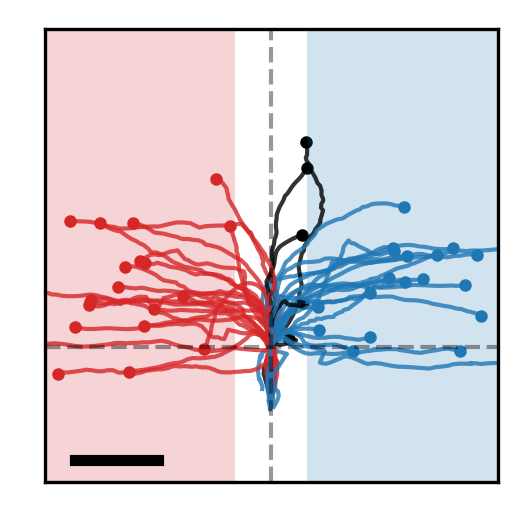

21 20 5


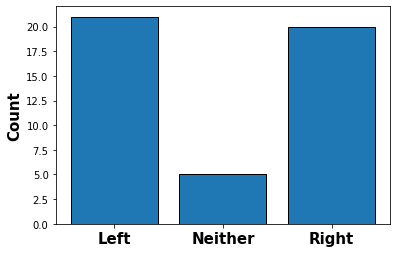

0.4878048780487805
_0.2Rad_
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_016
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_003
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_008
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_002
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_013
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_015
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_006
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_017
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_009
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_001
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_007
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_018
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_004
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_011
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_005
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_012
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_010
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_000


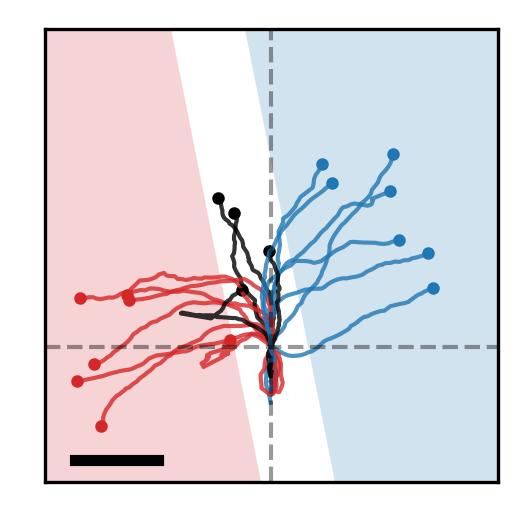

7 7 4


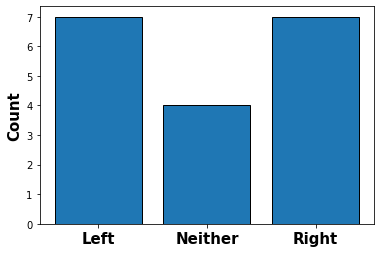

0.5
_0.39Rad_
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_013
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_011
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_003
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_000
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_014
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_006
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_007
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_012
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_009
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_008
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_016
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_001
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_010


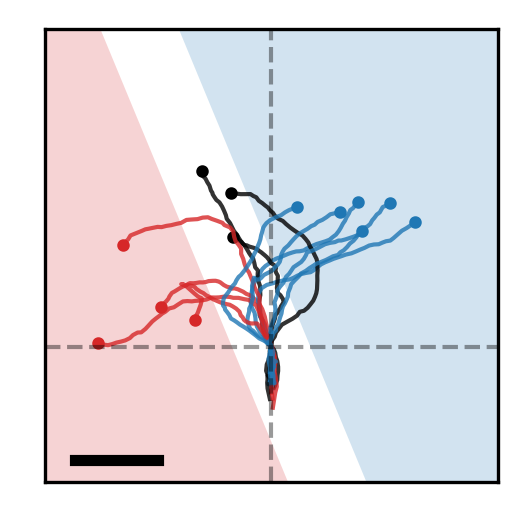

4 6 3


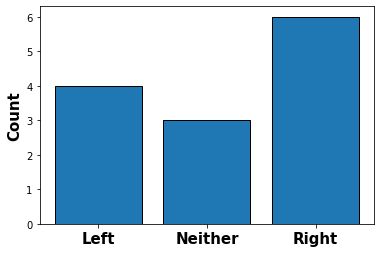

0.6
_0.79Rad_
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_004
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_001
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_009
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_000
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_008
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_013
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_010
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_002
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_011
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_007
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_016
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_015
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_006


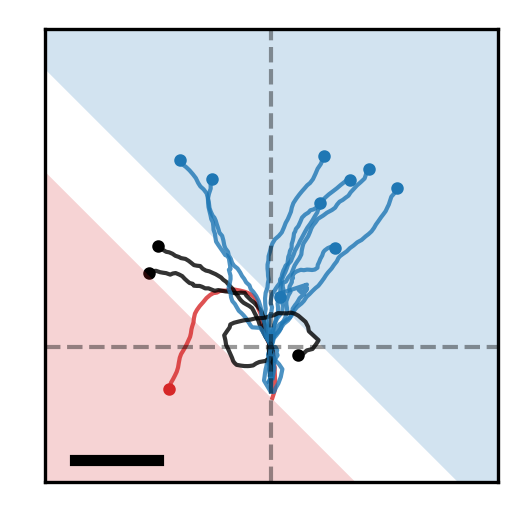

1 9 3


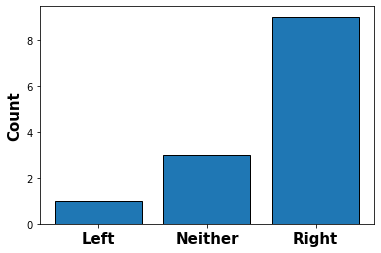

0.9
_1.57Rad_
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_1.57Rad_001
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_1.57Rad_005
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_1.57Rad_000
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_1.57Rad_003
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_1.57Rad_004
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_1.57Rad_009


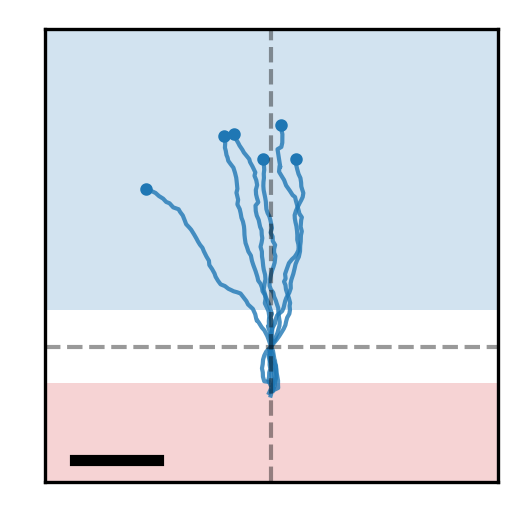

0 6 0


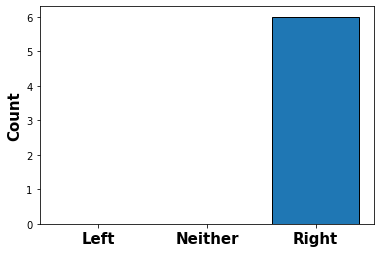

1.0


In [9]:

proportions_across_data = []
num_turning = []
cutoff = 20

angles = np.array([0, math.pi/16, math.pi/8, math.pi/4, math.pi/2])

count = 0
for delay in ['_0Rad_', '_0.2Rad_', '_0.39Rad_', '_0.79Rad_', '_1.57Rad_']:
    
    print(delay)
    
    
    exp_to_analyze = []

    parent_dir = '/home/jason/Data/simpleStimData/'
    for i in os.listdir(parent_dir):
        if (delay in i):
            print(i)
            exp_to_analyze.append(parent_dir + i)
            
        # special case because of messy naming: for 0Rad case, include other lateral 90 experiments
        if delay == '_0Rad_':
            if '_lateral90_50000' in i:
                exp_to_analyze.append(parent_dir + i)
                    
    exp_to_analyze = np.sort(exp_to_analyze)

    ALL_X_PATHS = []
    ALL_Y_PATHS = []


    plt.figure(figsize = (2, 2), dpi = 300)
    ax = plt.subplot(aspect = 'equal')
    
    for fnum in range(len(exp_to_analyze)):
        foldername = exp_to_analyze[fnum]

        im_path_list = np.sort([foldername + '/' + i.decode('ascii') for i in np.sort(os.listdir(foldername))])
        ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])

        x_stage_sequence = []
        y_stage_sequence = []

        for i in range(len(ch0_path_list)):
            with tifffile.TiffFile(ch0_path_list[i]) as temptif:
                #plt.imshow(temptif.asarray())

                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])

                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)

        x_stage_sequence = np.array(x_stage_sequence)
        y_stage_sequence = np.array(y_stage_sequence)

        x_translated = x_stage_sequence - x_stage_sequence[10] 
        y_translated = y_stage_sequence - y_stage_sequence[10]

        rotation_angle = np.arctan2(-np.average(np.diff(y_translated[:10])), np.average(np.diff(x_translated[:10])))

        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - rotation_angle + math.pi/2 - angles[count]

        x_rotated = rho * np.cos(phi)
        y_rotated = rho * np.sin(phi)
        final_loc = x_rotated[-1]
        if final_loc > cutoff:
            c = 'C0'
        elif final_loc < -cutoff:
            c = 'C3'
        else:
            c = 'k'
            
        ALL_X_PATHS.append(x_rotated)
        ALL_Y_PATHS.append(y_rotated)
          
        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - rotation_angle + math.pi/2

        x_rotated = rho * np.cos(phi)
        y_rotated = rho * np.sin(phi)
        plt.plot(x_rotated, y_rotated, color = c, alpha = 0.8, lw = 1)
        plt.scatter(x_rotated[-1], y_rotated[-1], color = c, s = 4)

        
    xvals = np.linspace(-125, 125, 100)
    A = angles[count]
    yvals1 = -1/np.tan(A) * xvals + cutoff * (np.sin(A) + np.cos(A)/np.tan(A))
    yvals2 = -1/np.tan(A) * xvals + cutoff * (-np.sin(A) - np.cos(A)/np.tan(A))
    
    
    plt.fill_between(xvals, yvals1, 180, facecolor = 'C0', alpha = 0.2)
    plt.fill_between(xvals, -80, yvals2, facecolor = 'C3', alpha = 0.2)
    
    if delay == '_0Rad_':
        xvals = np.linspace(cutoff, 125, 100)
        plt.fill_between(xvals, -80, 180, facecolor = 'C0', alpha = 0.2)
        xvals = np.linspace(-125, -cutoff, 100)
        plt.fill_between(xvals, -80, 180, facecolor = 'C3', alpha = 0.2)
        
    plt.axhline(0, ls = '--', color = 'k', alpha = 0.4, lw = 1)
    plt.axvline(0, ls = '--', color = 'k', alpha = 0.4, lw = 1)
    plt.axis([-125, 125, -75, 175])
    #plt.xlabel('X Position (µm)', fontweight = 'bold', fontsize = 8)
    #plt.ylabel('Y Position (µm)', fontweight = 'bold', fontsize = 8)
    plt.xticks([], fontsize = 5)
    plt.yticks([], fontsize = 5)

    rect = mp.Rectangle((-110, -65), 50, 4, color = 'k')
    ax.add_patch(rect)
    
    plt.show()

    final_loc = np.array([i[-1] for i in ALL_X_PATHS])


    left = np.sum(final_loc < -cutoff)
    neither = np.sum(np.abs(final_loc) < cutoff)
    right = np.sum(final_loc > cutoff)

    plt.bar([0, 1, 2], [left, neither, right], ec= 'k')
    plt.xticks([0, 1, 2], ['Left', 'Neither', 'Right'], fontweight = 'bold', fontsize = 15)
    plt.ylabel('Count', fontweight = 'bold', fontsize = 15)
    
    print(left, right, neither)
    plt.show()
    
    
    
    proportion_right = right/(left + right)
    
    print(proportion_right)
    
    proportions_across_data.append(proportion_right)
    num_turning.append(left + right)
    
    count += 1
    
    
proportions_across_data = np.array(proportions_across_data)

# Figure S5B
increase cutoff to show that results are not particular to a certain threshold value.

_0Rad_
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_003
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_013
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_007
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_016
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_005
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_004
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_009
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_012
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_006
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_014
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_001
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_015
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_010
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_002
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_017


/tmp/ipykernel_4603/3845000176.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  yvals1 = -1/np.tan(A) * xvals + cutoff * (np.sin(A) + np.cos(A)/np.tan(A))
/tmp/ipykernel_4603/3845000176.py:89: RuntimeWarning: invalid value encountered in add
  yvals1 = -1/np.tan(A) * xvals + cutoff * (np.sin(A) + np.cos(A)/np.tan(A))
/tmp/ipykernel_4603/3845000176.py:90: RuntimeWarning: divide by zero encountered in double_scalars
  yvals2 = -1/np.tan(A) * xvals + cutoff * (-np.sin(A) - np.cos(A)/np.tan(A))
/tmp/ipykernel_4603/3845000176.py:90: RuntimeWarning: invalid value encountered in add
  yvals2 = -1/np.tan(A) * xvals + cutoff * (-np.sin(A) - np.cos(A)/np.tan(A))


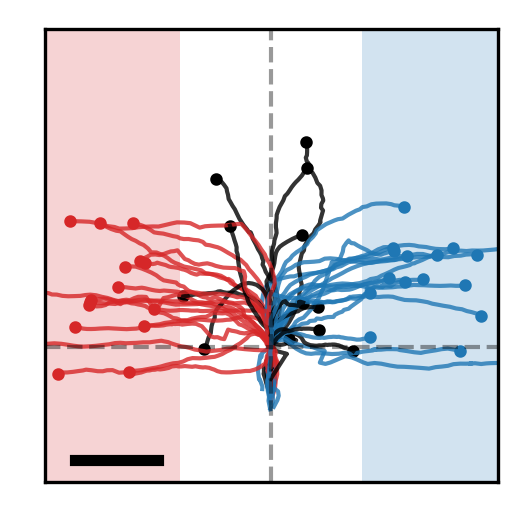

17 17 12


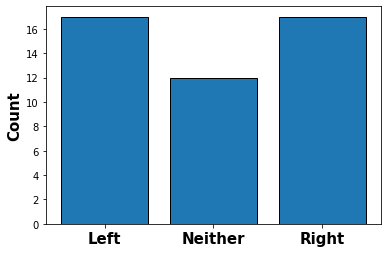

0.5
_0.2Rad_
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_016
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_003
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_008
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_002
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_013
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_015
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_006
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_017
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_009
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_001
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_007
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_018
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_004
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_011
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_005
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_012
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_010
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_000


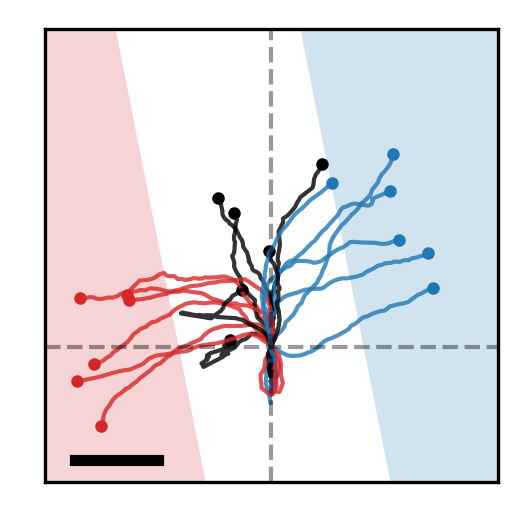

6 6 6


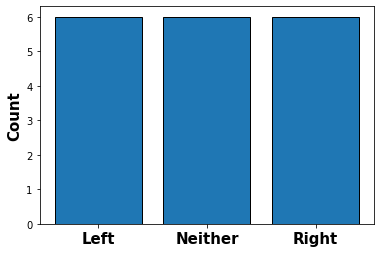

0.5
_0.39Rad_
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_013
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_011
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_003
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_000
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_014
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_006
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_007
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_012
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_009
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_008
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_016
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_001
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_010


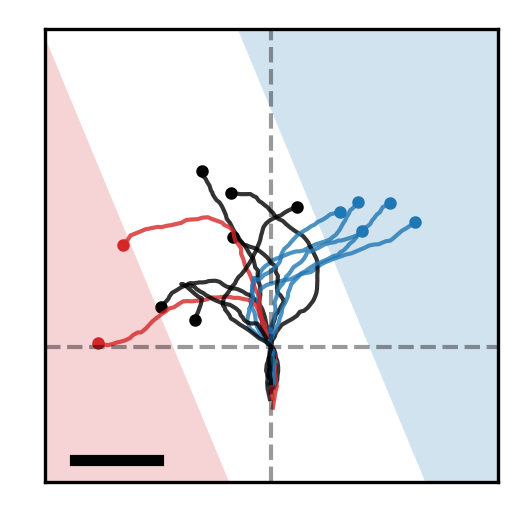

2 5 6


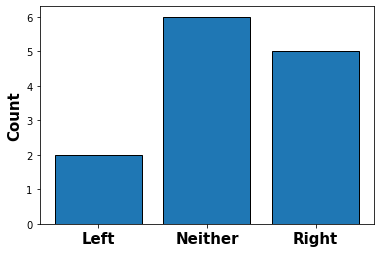

0.7142857142857143
_0.79Rad_
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_004
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_001
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_009
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_000
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_008
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_013
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_010
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_002
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_011
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_007
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_016
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_015
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_006


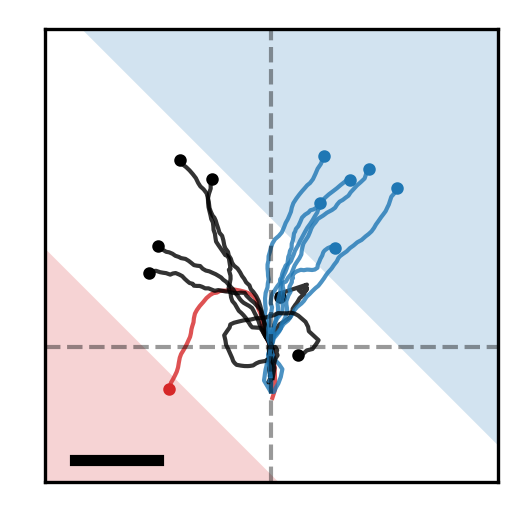

1 6 6


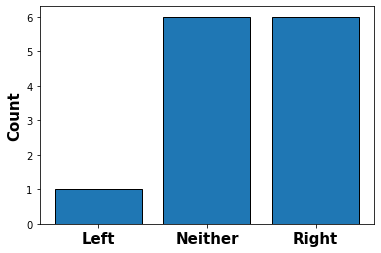

0.8571428571428571
_1.57Rad_
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_1.57Rad_001
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_1.57Rad_005
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_1.57Rad_000
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_1.57Rad_003
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_1.57Rad_004
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_1.57Rad_009


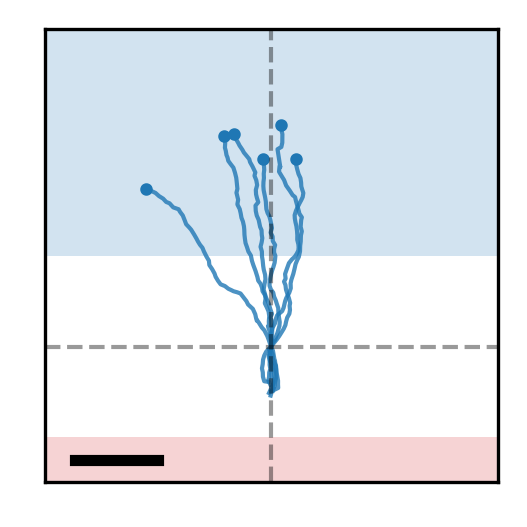

0 6 0


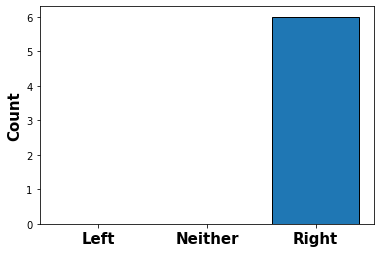

1.0


In [10]:

proportions_across_data = []
num_turning = []
cutoff = 50

angles = np.array([0, math.pi/16, math.pi/8, math.pi/4, math.pi/2])

count = 0
for delay in ['_0Rad_', '_0.2Rad_', '_0.39Rad_', '_0.79Rad_', '_1.57Rad_']:
    
    print(delay)
    
    
    exp_to_analyze = []

    parent_dir = '/home/jason/Data/simpleStimData/'
    for i in os.listdir(parent_dir):
        if (delay in i):
            print(i)
            exp_to_analyze.append(parent_dir + i)
            
        # special case because of messy naming: for 0Rad case, include other lateral 90 experiments
        if delay == '_0Rad_':
            if '_lateral90_50000' in i:
                exp_to_analyze.append(parent_dir + i)
                    
    exp_to_analyze = np.sort(exp_to_analyze)

    ALL_X_PATHS = []
    ALL_Y_PATHS = []


    plt.figure(figsize = (2, 2), dpi = 300)
    ax = plt.subplot(aspect = 'equal')
    
    for fnum in range(len(exp_to_analyze)):
        foldername = exp_to_analyze[fnum]

        im_path_list = np.sort([foldername + '/' + i.decode('ascii') for i in np.sort(os.listdir(foldername))])
        ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])

        x_stage_sequence = []
        y_stage_sequence = []

        for i in range(len(ch0_path_list)):
            with tifffile.TiffFile(ch0_path_list[i]) as temptif:
                #plt.imshow(temptif.asarray())

                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])

                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)

        x_stage_sequence = np.array(x_stage_sequence)
        y_stage_sequence = np.array(y_stage_sequence)

        x_translated = x_stage_sequence - x_stage_sequence[10] 
        y_translated = y_stage_sequence - y_stage_sequence[10]

        rotation_angle = np.arctan2(-np.average(np.diff(y_translated[:10])), np.average(np.diff(x_translated[:10])))

        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - rotation_angle + math.pi/2 - angles[count]

        x_rotated = rho * np.cos(phi)
        y_rotated = rho * np.sin(phi)
        final_loc = x_rotated[-1]
        if final_loc > cutoff:
            c = 'C0'
        elif final_loc < -cutoff:
            c = 'C3'
        else:
            c = 'k'
            
        ALL_X_PATHS.append(x_rotated)
        ALL_Y_PATHS.append(y_rotated)
          
        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - rotation_angle + math.pi/2

        x_rotated = rho * np.cos(phi)
        y_rotated = rho * np.sin(phi)
        plt.plot(x_rotated, y_rotated, color = c, alpha = 0.8, lw = 1)
        plt.scatter(x_rotated[-1], y_rotated[-1], color = c, s = 4)

        
    xvals = np.linspace(-125, 125, 100)
    A = angles[count]
    yvals1 = -1/np.tan(A) * xvals + cutoff * (np.sin(A) + np.cos(A)/np.tan(A))
    yvals2 = -1/np.tan(A) * xvals + cutoff * (-np.sin(A) - np.cos(A)/np.tan(A))
    
    
    plt.fill_between(xvals, yvals1, 180, facecolor = 'C0', alpha = 0.2)
    plt.fill_between(xvals, -80, yvals2, facecolor = 'C3', alpha = 0.2)
    
    if delay == '_0Rad_':
        xvals = np.linspace(cutoff, 125, 100)
        plt.fill_between(xvals, -80, 180, facecolor = 'C0', alpha = 0.2)
        xvals = np.linspace(-125, -cutoff, 100)
        plt.fill_between(xvals, -80, 180, facecolor = 'C3', alpha = 0.2)
        
    plt.axhline(0, ls = '--', color = 'k', alpha = 0.4, lw = 1)
    plt.axvline(0, ls = '--', color = 'k', alpha = 0.4, lw = 1)
    plt.axis([-125, 125, -75, 175])
    #plt.xlabel('X Position (µm)', fontweight = 'bold', fontsize = 8)
    #plt.ylabel('Y Position (µm)', fontweight = 'bold', fontsize = 8)
    plt.xticks([], fontsize = 5)
    plt.yticks([], fontsize = 5)

    rect = mp.Rectangle((-110, -65), 50, 4, color = 'k')
    ax.add_patch(rect)
    
    plt.show()

    final_loc = np.array([i[-1] for i in ALL_X_PATHS])


    left = np.sum(final_loc < -cutoff)
    neither = np.sum(np.abs(final_loc) < cutoff)
    right = np.sum(final_loc > cutoff)

    plt.bar([0, 1, 2], [left, neither, right], ec= 'k')
    plt.xticks([0, 1, 2], ['Left', 'Neither', 'Right'], fontweight = 'bold', fontsize = 15)
    plt.ylabel('Count', fontweight = 'bold', fontsize = 15)
    
    print(left, right, neither)
    plt.show()
    
    
    
    proportion_right = right/(left + right)
    
    print(proportion_right)
    
    proportions_across_data.append(proportion_right)
    num_turning.append(left + right)
    
    count += 1
    
    
proportions_across_data = np.array(proportions_across_data)

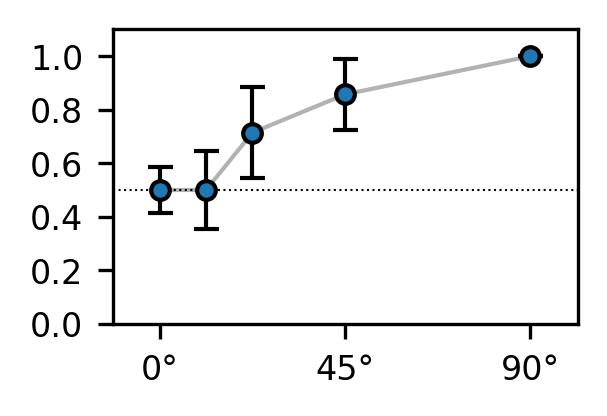

0.0 Rad, X: 0.5
0.2 Rad, X: 0.5
0.39 Rad, X: 0.71
0.79 Rad, X: 0.86
1.57 Rad, X: 1.0
[0.16806861 0.28290163 0.33466401 0.25922963 0.        ]


In [11]:
#Standard Error of Sample Proportion
sample_error = np.sqrt(proportions_across_data * (1 - proportions_across_data) / num_turning)
percent_confidence_interval_95 = 1.96 * sample_error


plt.figure(figsize = (2, 1.3), dpi = 300)
ax = plt.subplot()
plt.scatter(angles, proportions_across_data, zorder = 1, s = 20, lw = 1, ec = 'k')
plt.plot(angles, proportions_across_data, zorder = 0, alpha = 0.3, lw = 1, color = 'k')
plt.errorbar(angles, proportions_across_data, sample_error, color = 'k', zorder = 0, lw = 1, capsize = 3, ls = 'none')

'''
for i in range(len(proportions_across_data)):
    ax.text(angles[i], proportions_across_data[i] -sample_error[i] - 0.1, f'n = {num_turning[i]}', ha = 'center', fontweight = 'bold', fontsize = 6)
plt.xlabel('θ, Angle (rad)', fontweight = 'bold', fontsize = 8)
plt.ylabel('X, Proportion Turning\nToward "Frontward" Stimulus', fontweight = 'bold', fontsize = 8)
'''
plt.ylim(0.0, 1.1)

plt.xlim(-0.2, math.pi/2 + 0.2)
plt.xticks([0, math.pi/4, math.pi/2], ['0°', '45°', '90°'], fontsize = 8)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize = 8)
plt.axhline(0.5, ls = ':', color = 'k', zorder = -1, lw = 0.5)
plt.show()

for i, p in enumerate(proportions_across_data):
    print(str(np.round(angles[i], 2)) + ' Rad,', 'X: ' + str(np.round(p, 2)))
    
print(percent_confidence_interval_95)